# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

from tensorflow.keras import regularizers


%matplotlib inline

RESPONSE_VAR = 'temperature'
WINDOW_SIZE = 7
CONV_WIDTH = 3

In [2]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


In [3]:
df.shape

(45253, 6)

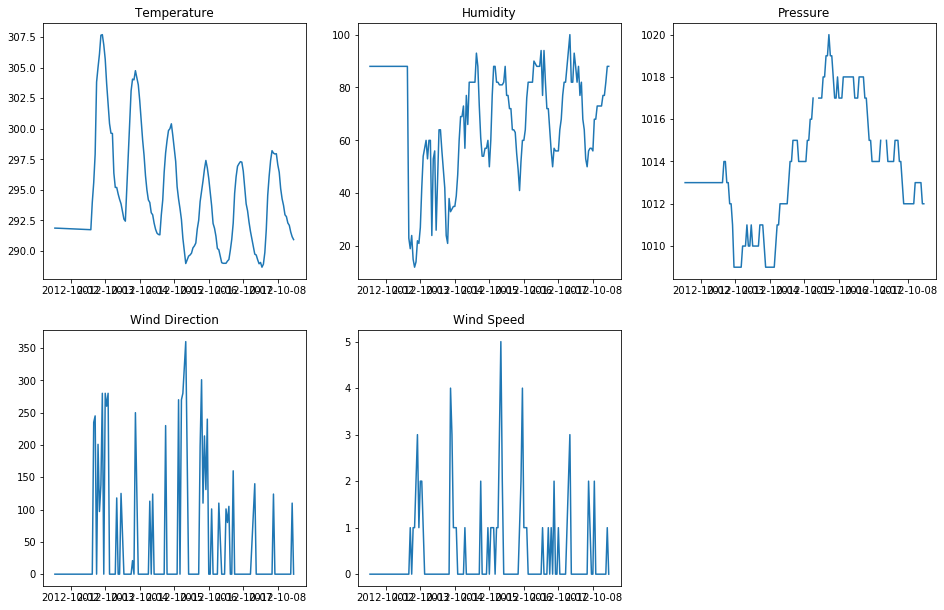

In [4]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [5]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [6]:
252 / df.shape[0]

0.0055686915784588864

In [7]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Feature Engineering
Converting Wind Speed and Direction into X-Y Wind Vectors

In [8]:
# Source: https://www.tensorflow.org/tutorials/structured_data/time_series

wv = df.pop('wind_s')
# Convert to radians.
wd_rad = df.pop('wind_d')*np.pi / 180

# Calculate the wind x and y components.
df['wind_x'] = wv*np.cos(wd_rad)
df['wind_y'] = wv*np.sin(wd_rad)

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

In [9]:
# Convert date col to numeric representation.

datetimes = df['datetime']

df = date_periodicity(df, date_col='datetime')

train_df, val_df, test_df = split_df(df)
# # Create copy of Dataframe for Noisy dataset creation.
# noisy_test_df = test_df.copy()

## Linear Model

In [10]:
train_df, val_df, test_df = split_df(df)
train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, dependent=RESPONSE_VAR)

#### Windowing data

In [11]:
single_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

# window

In [12]:
single_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [13]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, single_window)

# Clear output from Ipython display after compiling.
clear_output()

In [14]:
val_score, test_score = {}, {}

val_score['Linear'] = linear.evaluate(single_window.val)

283/283 [==============================] - 0s 825us/step - loss: 2.3458 - mean_absolute_error: 0.9762 - mean_absolute_percentage_error: 0.3336


In [15]:
test_score['Linear'] = linear.evaluate(single_window.test)

142/142 [==============================] - 0s 919us/step - loss: 1.3651 - mean_absolute_error: 0.8655 - mean_absolute_percentage_error: 0.2925


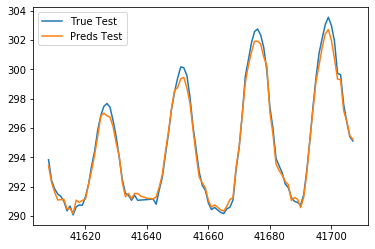

In [44]:
def rand_slice_indicies(df, sample_size=100):
    """Create a start and end index to be used for 
    Slicing for input df. Limitation as last sample_size ... n, will
    be excluded.
    
    Args:
        df (Dataframe): Input dataframe
        sample_size (int): Width of slice range (default 100)
        
    Returns:
        start_index (int): Start of slice
        end_index (int): End of slice
    """
    start_index = np.random.randint(low=0, high=df.shape[0]-sample_size)
    end_index = start_index + sample_size

    return start_index, end_index
    

#### Convolutional Model

In [45]:
CONV_WINDOW_SIZE = WINDOW_SIZE - 2

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


conv_window = WindowGenerator(
    input_width=CONV_WINDOW_SIZE + (CONV_WIDTH - 1), label_width=CONV_WINDOW_SIZE, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

compile_and_fit(conv_model, conv_window)
clear_output()

In [46]:
val_score['Conv'] = conv_model.evaluate(conv_window.val)

283/283 [==============================] - 0s 869us/step - loss: 4.3908 - mean_absolute_error: 1.5917 - mean_absolute_percentage_error: 0.5465


In [47]:
test_score['Conv'] = conv_model.evaluate(conv_window.test)

142/142 [==============================] - 0s 911us/step - loss: 3.4032 - mean_absolute_error: 1.4838 - mean_absolute_percentage_error: 0.5034


In [82]:
x = conv_model.predict(conv_window.make_dataset(test_df))
x[:,5,0]

IndexError: index 5 is out of bounds for axis 1 with size 5

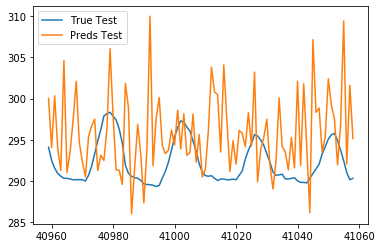

In [74]:
def create_model_preds_df(model, window):
    test_preds = model.predict(window.make_dataset(window.test_df))[:,0,0]

    test_true = window.test_df[RESPONSE_VAR][WINDOW_SIZE:]
    
    test_preds_df = pd.DataFrame({"True Test": test_true,
                                      "Preds Test": test_preds})
    
    return test_preds_df
    
conv_preds_df = create_model_preds_df(conv_model, conv_window)
    
start_index, end_index = rand_slice_indicies(conv_preds_df)

conv_preds_df[start_index: end_index].plot()

In [77]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(conv_preds_df['True Test'], conv_preds_df['Preds Test'])

5.396539980304013

#### Textbook Model

In [39]:
textbook_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
	tf.keras.layers.GRU(32, return_sequences=True),
	tf.keras.layers.GRU(32, return_sequences=True),
	tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))

])


compile_and_fit(textbook_model, conv_window)
clear_output()

In [40]:
val_score['Textbook'] = textbook_model.evaluate(conv_window.val)

283/283 [==============================] - 1s 2ms/step - loss: 42.0760 - mean_absolute_error: 5.0697 - mean_absolute_percentage_error: 1.7285


In [41]:
test_score['Textbook'] = textbook_model.evaluate(conv_window.test)

142/142 [==============================] - 0s 2ms/step - loss: 45.4207 - mean_absolute_error: 5.2031 - mean_absolute_percentage_error: 1.7430


In [59]:
textbook_model_drop = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.GRU(32, 
                        return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.GRU(32, 
                        return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])

compile_and_fit(textbook_model_drop, conv_window)
clear_output()

In [62]:
val_score['Text_drop'] = textbook_model_drop.evaluate(conv_window.val)

283/283 [==============================] - 1s 2ms/step - loss: 321.7400 - mean_absolute_error: 16.7486 - mean_absolute_percentage_error: 5.7050


In [63]:
test_score['Text_drop'] = textbook_model_drop.evaluate(conv_window.test)

142/142 [==============================] - 0s 2ms/step - loss: 437.6165 - mean_absolute_error: 20.3222 - mean_absolute_percentage_error: 6.8664


#### Bidirectional Wrapper

In [64]:
textbook_model_drop_bi = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, 
                        return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01))),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, 
                        return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01))),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])

compile_and_fit(textbook_model_drop_, conv_window)
clear_output()

In [65]:
val_score['Text_drop_bi'] = textbook_model_drop_bi.evaluate(conv_window.val)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
test_score['Text_drop_bi'] = textbook_model_drop_bi.evaluate(conv_window.test)

#### Recurrent Models
##### Long Short Term Memory (LSTM)

In [33]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(lstm_model, single_window)
clear_output()

In [35]:
val_score['LSTM'] = lstm_model.evaluate(single_window.val)

283/283 [==============================] - 1s 2ms/step - loss: 15634.3760 - mean_absolute_error: 124.4652 - mean_absolute_percentage_error: 42.7024


In [36]:
test_score['LSTM'] = lstm_model.evaluate(single_window.test)

142/142 [==============================] - 0s 2ms/step - loss: 16521.6602 - mean_absolute_error: 128.0460 - mean_absolute_percentage_error: 43.4098


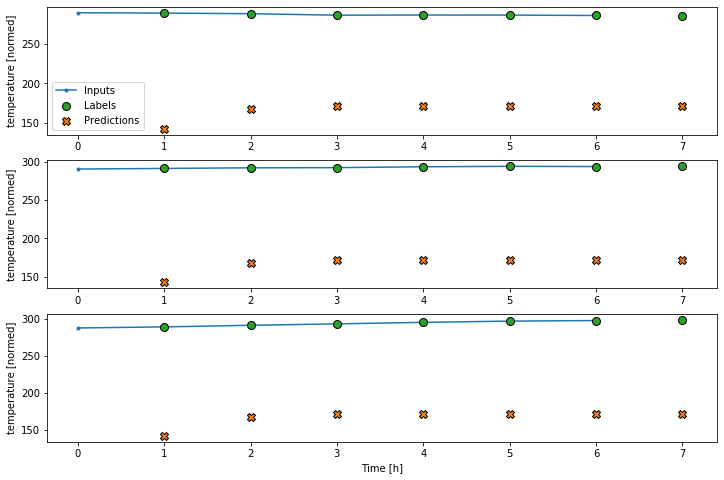

In [38]:
single_window.plot(model=lstm_model, plot_col=RESPONSE_VAR)